# телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

**Информация о договоре**

In [160]:
try:
    df_contract = pd.read_csv('contract.csv') 
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv') 

In [161]:
display(df_contract.duplicated().sum())
display(df_contract.info())
display(df_contract.isna().sum())
df_contract.head(5)

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


*Добавим сразу столбецс с таргетом, всем ушедшим клиентам присвоим номер 1, оставшимся 0*

In [162]:

df_contract['target'] = df_contract['EndDate']
def target(target):
    if target == 'No':
        return 0
    else:
        return 1
df_contract['target'] = df_contract['target'].apply(target)

df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


*Посчитаю "время жизни" клиента в месяцах и добавлю столбец month. Дата окончания - это дата получения датасета.*

In [163]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df_contract[['BeginDate', 'EndDate']] = df_contract[['BeginDate', 'EndDate']].astype("datetime64")
df_contract["day"] = (df_contract["EndDate"] - df_contract["BeginDate"]).dt.days

df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [164]:
#df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
#df_contract[['BeginDate', 'EndDate']] = df_contract[['BeginDate', 'EndDate']].astype("datetime64")
#df_contract["month"] = (((df_contract["EndDate"] - df_contract["BeginDate"])/np.timedelta64(1, 'M'))).astype('int')
#df_contract.head(5)

*При изменение столбца TotalCharges на float, были найдены пустые значения. Пустые значения у клиентов, которые зарегистрировались в феврале и тип оплаты годовой или двухгодовой. Заменю пустые значения на значения из MonthlyCharges*

In [165]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


In [166]:
def empty(row):
    if row['TotalCharges'] == ' ':
        x = row['MonthlyCharges']
        return x
    else:
        y = row['TotalCharges']
        return y

df_contract['TotalCharges'] = df_contract.apply(empty, axis=1)


In [167]:
df_contract.loc[488]

customerID                         4472-LVYGI
BeginDate                 2020-02-01 00:00:00
EndDate                   2020-02-01 00:00:00
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                            52.55
target                                      0
day                                         0
Name: 488, dtype: object

In [168]:
# переведу значения во float
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges']) 

In [169]:
display(df_contract.head(5))
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   day               7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


**Персональные данные клиента**

In [170]:

try:
    df_personal = pd.read_csv('personal.csv') 
except:
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv') 

In [171]:
display(df_personal.duplicated().sum())
display(df_personal.info())
display(df_personal.isna().sum())
df_personal.head(5)

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Информация об интернет-услугах**

In [172]:
try:
    df_internet = pd.read_csv('internet.csv') 
except:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv') 

In [173]:
display(df_internet.duplicated().sum())
display(df_internet.info())
display(df_internet.isna().sum())
df_internet.head(5)

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


информация об интернет-услугах в норме

**Информация об услугах телефонии**

In [174]:
try:
    df_phone = pd.read_csv('phone.csv') 
except:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv') 

In [175]:
display(df_phone.duplicated().sum())
display(df_phone.info())
display(df_phone.isna().sum())
df_phone.head(5)

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

customerID       0
MultipleLines    0
dtype: int64

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


*объединим все таблицы в одну*

In [176]:
df = df_contract.merge(df_personal, on='customerID', how='left')
df = df.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')

In [177]:
display(df.head(5))
df.shape

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No


(7043, 22)

*После объдинения таблиц, так как некоторые клиенты пользовались не всеми услугами, образовались пропущенные значения. так как клиент не пользовался услцгой, заменю все значения на ноль*

In [178]:
display(df.isna().sum())
df = df.fillna('No')
df.isna().sum()


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
day                    0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
day                 0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

*Удалю столбцы с датами, так как уже подсчитал время "жизни" клиента и id клиента.*

In [179]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [180]:
df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   target            7043 non-null   int64  
 6   day               7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


*Преобразуем категориальные признаки в численные методом One-hot-encoding для определенных моделей*

In [182]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [183]:
df_ohe.head(5)

,MonthlyCharges,TotalCharges,target,day,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,31,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,1036,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,1,61,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,1371,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,1,61,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


In [184]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7043 non-null   float64
 1   TotalCharges                           7043 non-null   float64
 2   target                                 7043 non-null   int64  
 3   day                                    7043 non-null   int64  
 4   SeniorCitizen                          7043 non-null   int64  
 5   Type_One year                          7043 non-null   uint8  
 6   Type_Two year                          7043 non-null   uint8  
 7   PaperlessBilling_Yes                   7043 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 9   PaymentMethod_Electronic check         7043 non-null   uint8  
 10  PaymentMethod_Mailed check             7043 non-null   uint8  
 11  gend

**Вывод**

Загрузил даные по всем таблицам.

Провел предобработку данных. Добавил столбец target.

Посчитал время "жизни" клиента в месяцах. Изменил числовые типы данных на float. 

Данные в столбцах  Yes и  No заменил на 1 и 0 соответсвенно.

После соединения таблиц, заполнил пропуски 0.

Провел прямое кодирование признаков с  использованием дамми ловушек

*Выделим  target*

In [185]:
target = df_ohe['target']
features = df_ohe.drop(['target'], axis=1)

In [187]:
# отделил обучающаую выборку, взял 80%
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=250722)


In [188]:
features_train.shape, features_test.shape

((5634, 22), (1409, 22))

*Отмасштабирую количественные признаки*

In [189]:
numeric = ['MonthlyCharges', 'TotalCharges', 'day']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [190]:
features_train

,MonthlyCharges,TotalCharges,day,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4244,-1.486564,-0.624577,0.560311,0,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1179,0.987190,0.748224,0.438162,1,0,0,1,0,1,0,...,0,1,0,0,1,0,1,1,0,1
2621,0.482816,1.462720,1.583147,0,0,1,1,1,0,0,...,0,0,0,0,1,1,1,1,1,0
2567,1.035304,1.541653,1.130790,0,0,0,1,0,1,0,...,0,1,0,0,1,1,0,1,0,1
5388,-1.481587,-0.995457,-1.278645,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,-1.479928,-0.995435,-1.278645,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
461,0.162605,-0.288741,-0.340375,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1032,0.914188,-0.680679,-0.995419,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,1,0
6269,-1.031964,-0.483003,0.111982,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0


## Подбор гиперпараметров для моделей

In [191]:
# словарь с результатами auc_roc
best = {}

In [192]:
param_grid = {'class_weight':['balanced', None], 
              'solver': ['liblinear'],
             'penalty': ['l1', 'l2', 'elasticnet', None],
             'multi_class': ['auto', 'ovr', 'multinomial']
             }
model = LogisticRegression(random_state=250722)
search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
search.fit(features_train, target_train)
print(f'Лучшие  гиперпараметры LogisticRegression: {search.best_params_} \nAUC-ROC = {search.best_score_:.4f}')

best['LinearRegression'] = search.best_score_

Лучшие  гиперпараметры LogisticRegression: {'class_weight': None, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'} 
AUC-ROC = 0.8430


In [193]:
param_grid = {'class_weight':['balanced', None], 
             'criterion': ['gini', 'entropy', 'log_loss'],
             'splitter':['best', 'random'],
             'max_depth': range(1, 20),
             'min_samples_leaf': range(1, 20, 3)
             }
model = DecisionTreeClassifier(random_state=250722)
search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
search.fit(features_train, target_train)
print(f'Лучшие  гиперпараметры DecisionTreeClassifier: {search.best_params_} \nAUC-ROC = {search.best_score_:.4f}')

best['DecisionTreeClassifier'] = search.best_score_

Лучшие  гиперпараметры DecisionTreeClassifier: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 19, 'splitter': 'best'} 
AUC-ROC = 0.8490


In [194]:
param_grid = {'depth' : [6,8,10],
             'learning_rate' : [0.01, 0.05],
             'iterations'    : [500, 1000]
             }
model = CatBoostClassifier(random_state=250722)
search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
search.fit(features_train, target_train, verbose=False)
print(f'Лучшие  гиперпараметры CatBoostRegressor: {search.best_params_} \nAUC-ROC = {search.best_score_:.4f}')

best['CatBoostRegressor'] = search.best_score_

Лучшие  гиперпараметры CatBoostRegressor: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.05} 
AUC-ROC = 0.9098


In [195]:
param_grid = {'num_leaves': [7, 14, 21, 28, 31, 50],
            'learning_rate': [0.1, 0.03, 0.003],
            'max_depth': [3, 5, 7],
            'n_estimators': [5, 10, 15, 20]
             }
model = LGBMClassifier(random_state=250722)
search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
search.fit(features_train, target_train, verbose=100)
print(f'Лучшие  гиперпараметры LGBMRegressor: {search.best_params_} \nAUC-ROC = {search.best_score_:.4f}')

best['LGBMRegressor'] = search.best_score_

Лучшие  гиперпараметры LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20, 'num_leaves': 28} 
AUC-ROC = 0.8717


In [196]:
param_grid = {'class_weight':['balanced', None],           
             'max_depth': range(1, 20, 2),
              'n_estimators': range(1, 20, 2),
              'min_samples_leaf': range(1, 20, 3)
             }
model = RandomForestClassifier(random_state=250722)
search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
search.fit(features_train, target_train)
print(f'Лучшие  гиперпараметры RandomForestClassifier: {search.best_params_}, AUC-ROC = {search.best_score_:.4f}')

best['RandomForestClassifier'] = search.best_score_

Лучшие  гиперпараметры RandomForestClassifier: {'class_weight': None, 'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 17}, AUC-ROC = 0.8551


In [197]:
for model, index in sorted(best.items(), key=lambda item: item[1], reverse=True):
    print(f'Модель {model} - AUC-ROC = {index:.4f}')

Модель CatBoostRegressor - AUC-ROC = 0.9098
Модель LGBMRegressor - AUC-ROC = 0.8717
Модель RandomForestClassifier - AUC-ROC = 0.8551
Модель DecisionTreeClassifier - AUC-ROC = 0.8490
Модель LinearRegression - AUC-ROC = 0.8430


**Вывод:**

Подобрал лучшие  гиперпараметры с помощью  GridSearchCV. 

Наилучший показатель показала модель CatBoostRegressor AUC-ROC = 0.9098 на обучающей выборке. 

## Проверка моделей на тестовой выборки. 

In [198]:
# словарь с результатами auc_roc на тестовой выборке
best_test = {}

In [199]:
model = LogisticRegression(random_state=250722, class_weight=None, multi_class='auto', penalty='l1', solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f"AUC-ROC на тестовой выборке = {auc_roc:.4f}")

best_test['LogisticRegression'] = auc_roc

AUC-ROC на тестовой выборке = 0.8563


In [200]:
model = DecisionTreeClassifier(random_state=250722,  criterion='entropy', max_depth=9, min_samples_leaf=19, splitter='best')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f"AUC-ROC на тестовой выборке = {auc_roc:.4f}")

best_test['DecisionTreeClassifier'] = auc_roc

AUC-ROC на тестовой выборке = 0.8590


In [201]:
model = RandomForestClassifier(random_state=250722, class_weight=None, max_depth=7, min_samples_leaf=4, n_estimators=17)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f"AUC-ROC на тестовой выборке = {auc_roc:.4f}")

best_test['RandomForestClassifier'] = auc_roc

AUC-ROC на тестовой выборке = 0.8677


In [202]:
model = LGBMClassifier(random_state=250722, learning_rate=0.1, max_depth=7, n_estimators=20, num_leaves=28)
model.fit(features_train, target_train)
predicted_test = model.predict_proba(features_test)[:,1]
auc_roc = roc_auc_score(target_test, predicted_test)
print(f"AUC-ROC на тестовой выборке = {auc_roc:.4f}")

best_test['LGBMRegressor'] = auc_roc

AUC-ROC на тестовой выборке = 0.8835


In [203]:
model = CatBoostClassifier(random_state=250722, depth=6, iterations=1000, learning_rate=0.05)
model.fit(features_train, target_train, verbose=False)
predicted_test = model.predict_proba(features_test)[:,1]
auc_roc = roc_auc_score(target_test, predicted_test)
print(f"AUC-ROC на тестовой выборке = {auc_roc:.4f}")

best_test['CatBoostRegressor'] = auc_roc

AUC-ROC на тестовой выборке = 0.9211


In [204]:
for model, index in sorted(best_test.items(), key=lambda item: item[1], reverse=True):
    print(f'Модель {model} - AUC-ROC = {index:.4f}')

Модель CatBoostRegressor - AUC-ROC = 0.9211
Модель LGBMRegressor - AUC-ROC = 0.8835
Модель RandomForestClassifier - AUC-ROC = 0.8677
Модель DecisionTreeClassifier - AUC-ROC = 0.8590
Модель LogisticRegression - AUC-ROC = 0.8563


### Вывод

При проверке результатов на тестовой выборке, лучший результат также у модели CatBoostRegressor - AUC-ROC = 0.9211

**Визуализация ROC-кривой** 

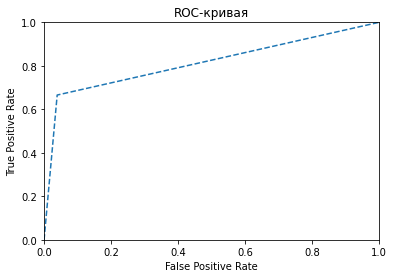

In [205]:
model = CatBoostClassifier(random_state=250722, depth=6, iterations=1000, learning_rate=0.05)
model.fit(features_train, target_train, verbose=False)
predicted_test = model.predict(features_test)
fpr, tpr, thresholds = roc_curve(target_test, predicted_test)
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")

plt.show()

**Визуализация важности признаков**

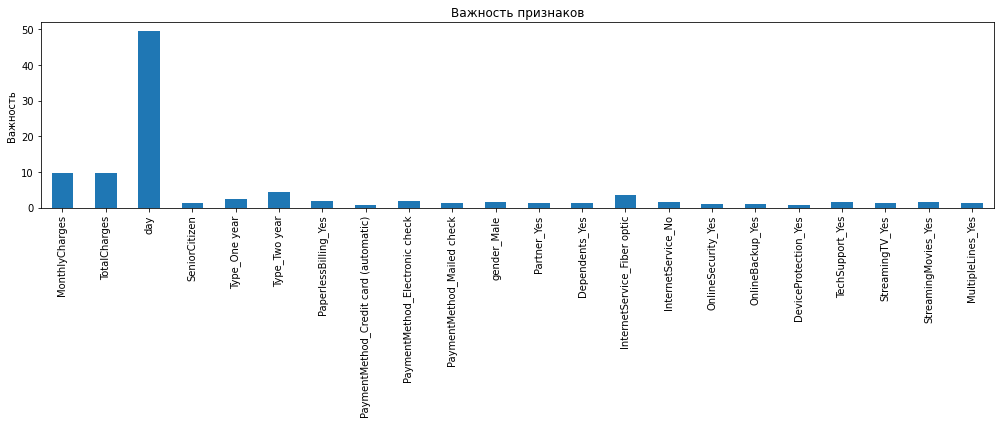

In [206]:
model = CatBoostClassifier(random_state=250722, depth=6, iterations=1000, learning_rate=0.05)
model.fit(X = df_ohe.drop(['target'], axis=1), y = df_ohe['target'], verbose=False)

skl_iris_imp = pd.Series(model.feature_importances_, df_ohe.drop(['target'], axis=1).columns)

fig, ax = plt.subplots(figsize=(14, 6))
skl_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

# Общий вывод

Провел исследования по прогнозированию оттока клиентов. Задача стояла разработать модель с AUC-ROC > 0.77.

Подготовил данные, удалил лишние критерии,  соединил в одну таблицу и провел исследование.

Подобрал лучшие  гиперпараметры с помощью  GridSearchCV и проверил на тестовой выборке

Наилучший показатель показала модель CatBoostRegressor AUC-ROC = 0.9211 на обучающей выборке. 